## DeepCycle
### In this notebook we experiment with 3-class model.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# curated_tracks - cell tracks syncronized on 1 division events
# double_division_tracks - cell tracks syncronized on 2 division events
from const import double_division_tracks, curated_tracks, DATA_ROOT

import pickle
import numpy as np
from numpy import savez_compressed, load
import pandas as pd
import cv2
import sompy
from scipy.interpolate import interp1d, NearestNDInterpolator
from scipy.stats import pearsonr

%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase, Colorbar
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')

from notebook_functions import umap_transform, plot_distributions, correlation_plot,\
                timelapse_single_frame_sync, timelapse_double_frame_sync,\
                circular_tracking, normalize_intensities, project_onto_fluo_plane

log_const = 300

In [2]:
cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std_3cls.csv')

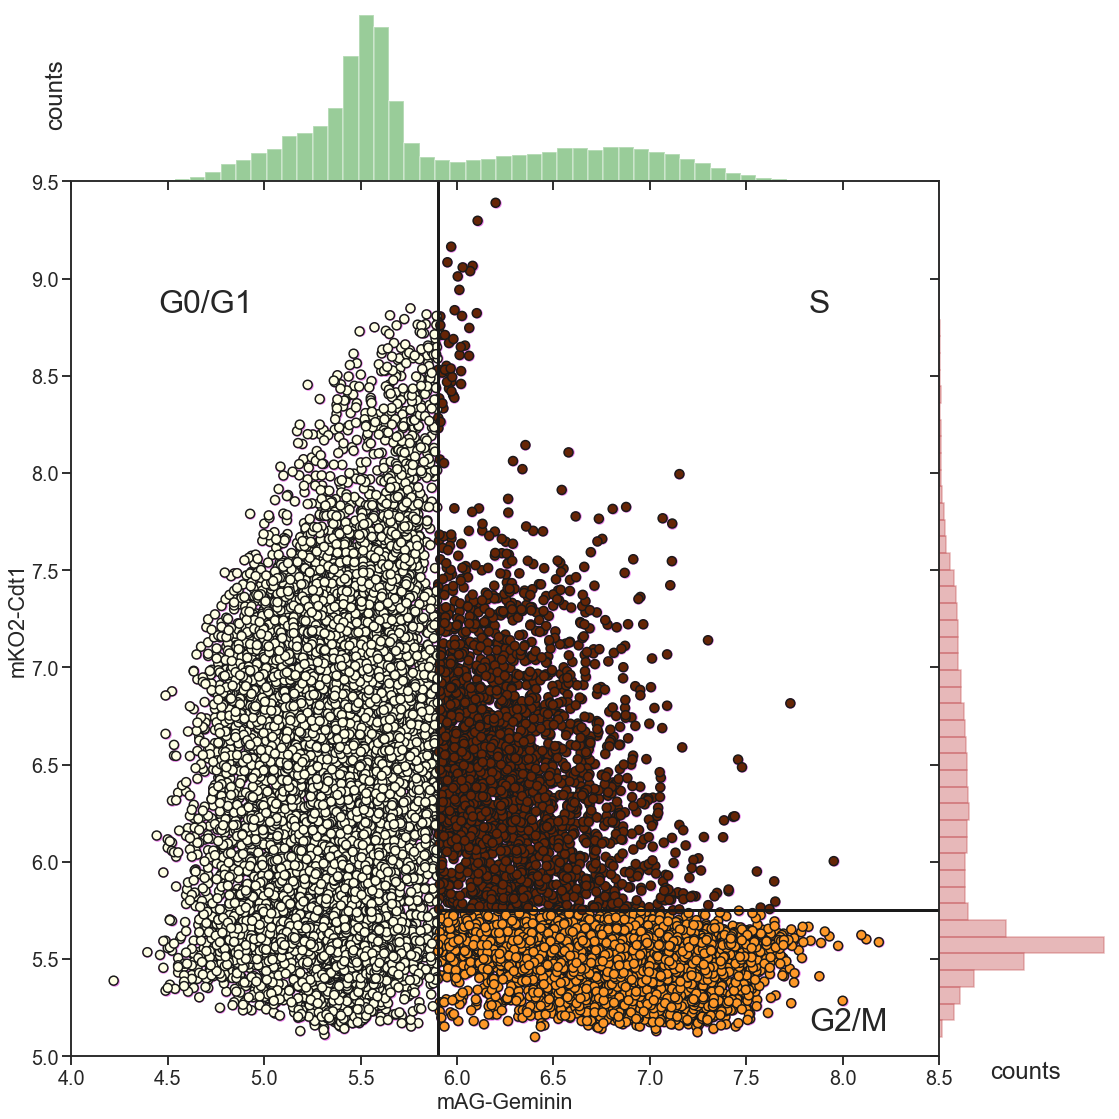

In [3]:
gr = np.log(cell_df[['GFP_20', 'Cy3_20']].values + log_const)

sns.set(style='ticks', color_codes=True)
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3.0})
linewidth = 10
fontsize = 24

x, y, labels = gr[::100, 0], gr[::100, 1], cell_df['cls3'][::100]
grid = sns.jointplot(x='mAG-Geminin', y='mKO2-Cdt1',
                     data=pd.DataFrame(data={'mAG-Geminin': x, 'mKO2-Cdt1': y}),
                     xlim=(4, 8.5), ylim=(5.0, 9.5),
                     color='violet',
                     space=0,
                     kind="scatter",
                     height=16,
                     marginal_kws={'color': 'green'})
plt.setp(grid.ax_marg_y.patches, color='r')

grid.ax_joint.scatter(x, y, c=labels, edgecolors='k', cmap='YlOrBr')
grid.ax_joint.vlines(x=5.9, ymin=5.0, ymax=9.5)
grid.ax_joint.hlines(y=5.75, xmin=5.9, xmax=8.5)
grid.ax_joint.text(0.1, 0.85, s='G0/G1', transform=grid.ax_joint.transAxes, fontsize=32)
grid.ax_joint.text(0.85, 0.85, s='S', transform=grid.ax_joint.transAxes, fontsize=32)
grid.ax_joint.text(0.85, 0.03, s='G2/M', transform=grid.ax_joint.transAxes, fontsize=32)
grid.ax_marg_x.set_ylabel('counts', fontsize=fontsize)
grid.ax_marg_y.set_xlabel('counts', fontsize=fontsize)
plt.show()

Accuracy: 0.860248128780888
[[0.90503836 0.08915613 0.00580552]
 [0.11930823 0.87872154 0.00197023]
 [0.39226519 0.57734807 0.03038674]]


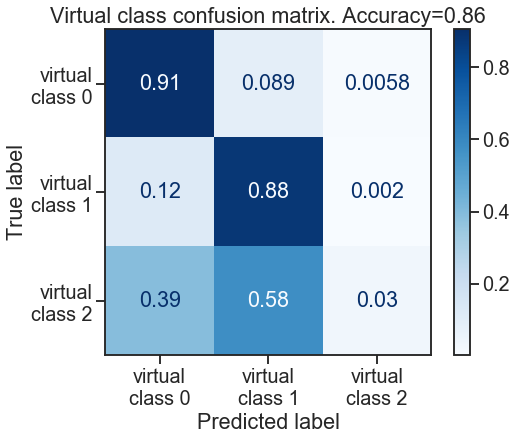

(9753, 3) (9753, 3) (9753, 2)


In [4]:
# load cell descriptors where 
# y - true class [1..4] one hot encoded, 
# descriptors - 4-component vectors obtained on validation set; validation set is double_division_tracks, 
# intensities - 2-component intensities of the cell

with open(DATA_ROOT / 'descriptors.cls3.r34.sz48.pkl', 'rb') as f:
    y, descriptors, intensities, df_index = pickle.load(f)
    
y_pred = np.argmax(descriptors, axis=1)
y_true = np.argmax(y, axis=1)
classes = sorted(np.unique(y_true))

acc = (y_pred == y_true).sum() / len(y_pred)
print('Accuracy:', acc)

confusion_mx = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize='true')
print(confusion_mx)

nl = '\n'
disp = ConfusionMatrixDisplay(confusion_mx, [f'virtual{nl}class {c}' for c in classes])
_ = disp.plot(cmap='Blues')
fig = plt.gcf()
_ = fig.set_size_inches(8, 6)
_ = disp.ax_.set_title(f'Virtual class confusion matrix. Accuracy={acc:.2f}')
# fig.savefig('conf_matrix_2channel.png', dpi=100)
plt.show()

descriptors = np.log(descriptors + 1e-7)
intensities = np.log(intensities + log_const)
print(y.shape, descriptors.shape, intensities.shape)

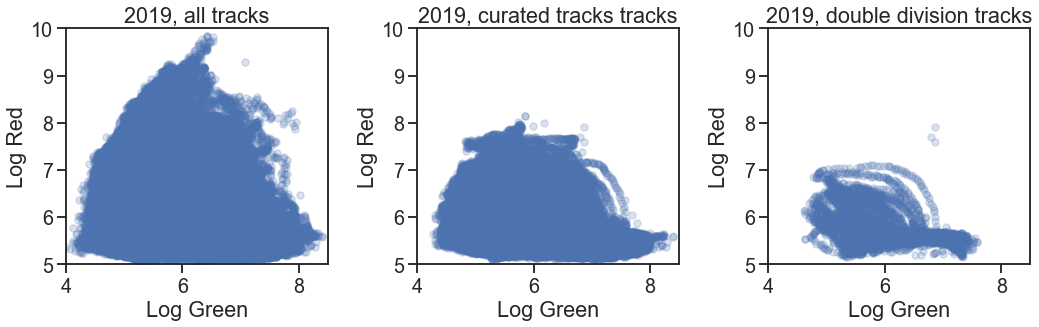

In [5]:
# load cell statistics and plot distributions for all, curated and double division tracks - across all frames.

cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std.csv')
intensities_all = cell_df[['GFP_20', 'Cy3_20']].values
intensities_all = np.log(intensities_all + log_const)

intensities_curated_tracks = cell_df.loc[cell_df['TRACK_ID'].isin(curated_tracks), ['GFP_20', 'Cy3_20']].values
intensities_curated_tracks = np.log(intensities_curated_tracks + log_const)

intensities_double_division = cell_df.loc[cell_df['TRACK_ID'].isin(double_division_tracks), ['GFP_20', 'Cy3_20']].values
intensities_double_division = np.log(intensities_double_division + log_const)


plot_distributions((intensities_all, '2019, all tracks'),
                   (intensities_curated_tracks, '2019, curated tracks tracks'),
                   (intensities_double_division, '2019, double division tracks'))

## Timelapse

In [6]:
# 'intensities.csv' contains ~1000 tracks synchronized on 1 division event in 'time' column

df = pd.read_csv(DATA_ROOT / 'intensities.csv', header=[0, 1, 2])

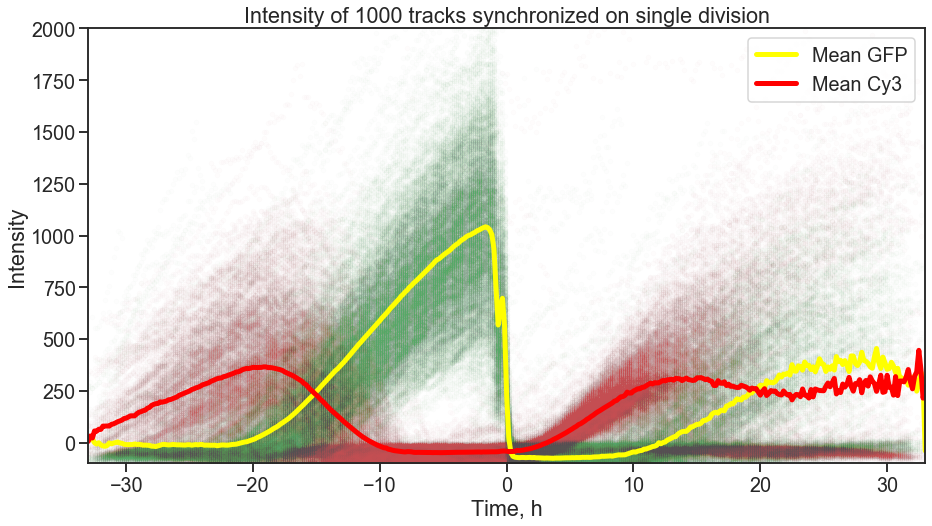

In [7]:
# plot average intensities of single division tracks

average_single_division_track = timelapse_single_frame_sync(df, curated_tracks)

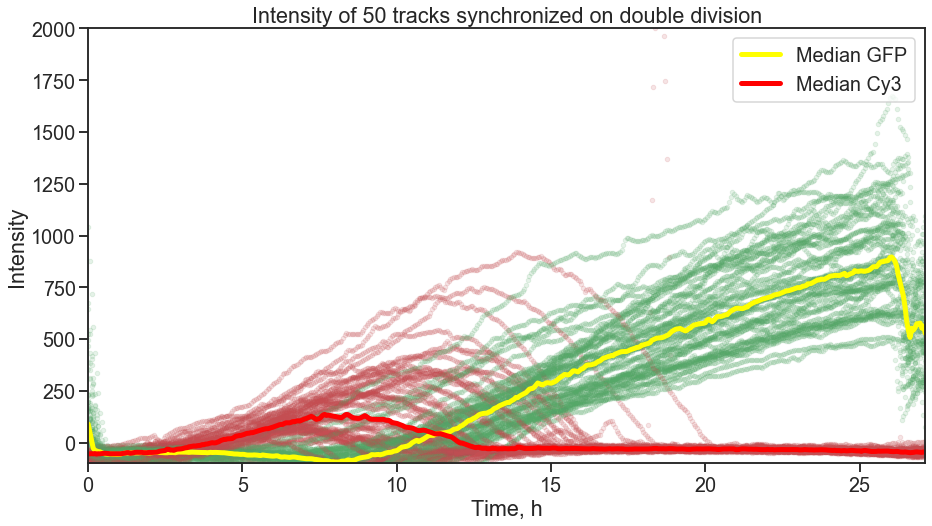

In [8]:
# plot average intensities of double division tracks

average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500)

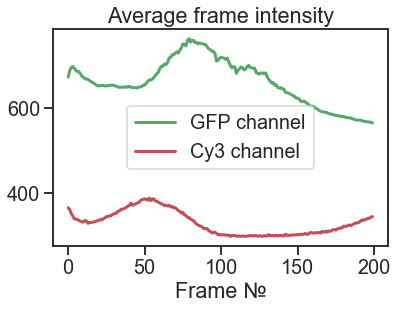

In [9]:
# plot average frame intensities for GFP and Cy3 channels

g_mean_tl, r_mean_tl = df[['gfp_frame_average', 'cy3_frame_average']].T.values

plt.plot(g_mean_tl, 'g', label='GFP channel')
plt.plot(r_mean_tl, 'r', label='Cy3 channel')
plt.legend(loc = 'center')
plt.title('Average frame intensity')
plt.xlabel('Frame №')
plt.show()

## U-Map embedding

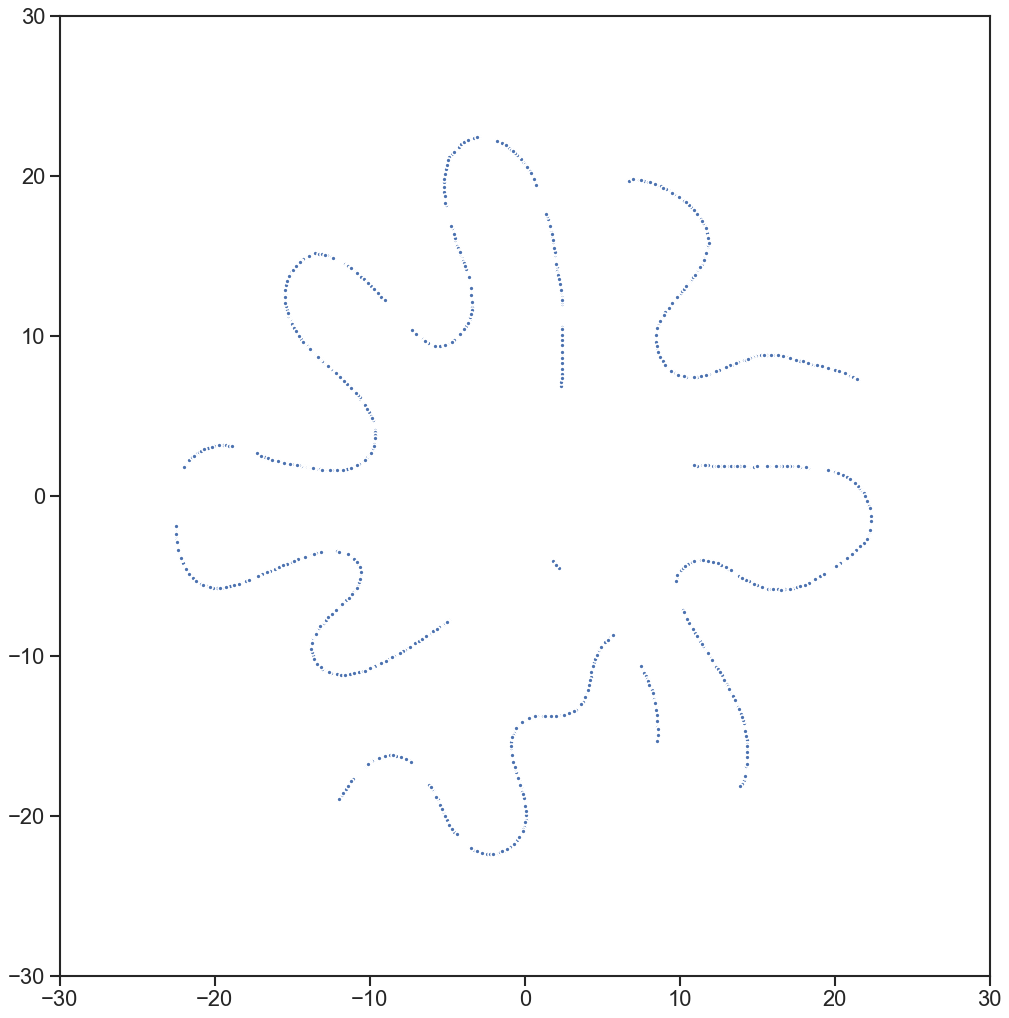

In [20]:
embeddings_preds, fit = umap_transform(descriptors, n_neighbors=500, min_dist=0.01, n_components=2, metric='correlation')

fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_preds[:, 0], embeddings_preds[:, 1])

## Finding average track with SOM clustering

In [21]:
mapsize = 100
som = sompy.SOMFactory.build(embeddings_preds, mapsize, mask=None, mapshape='cylinder', lattice='rect',
                             normalization='None', initialization='spherical', neighborhood='gaussian',
                             training='batch', name='sompy', track_history=True)
som.train(n_job=1, verbose=None)

som_matrix = som.codebook.matrix  # SOM track coordinates, shape = mapsize x 2
som_bmu = som._bmu[0].astype(int) # assigned SOM class,  shape = len(embeddings_preds)

input was considered as the numbers of nodes
map size is [1,100]


In [22]:
som_translation_tbl = np.roll(np.arange(mapsize), 0)
som_matrix = som_matrix[som_translation_tbl]
som_bmu = som_translation_tbl[som_bmu]

In [23]:
fun = np.median
som_track = []
for cluster in np.sort(np.unique(som_bmu)):
    som_track.append(fun(intensities[som_bmu == cluster], 0))
som_track = np.array(som_track)  # average intensities of SOM clusters, shape = mapsize x 2

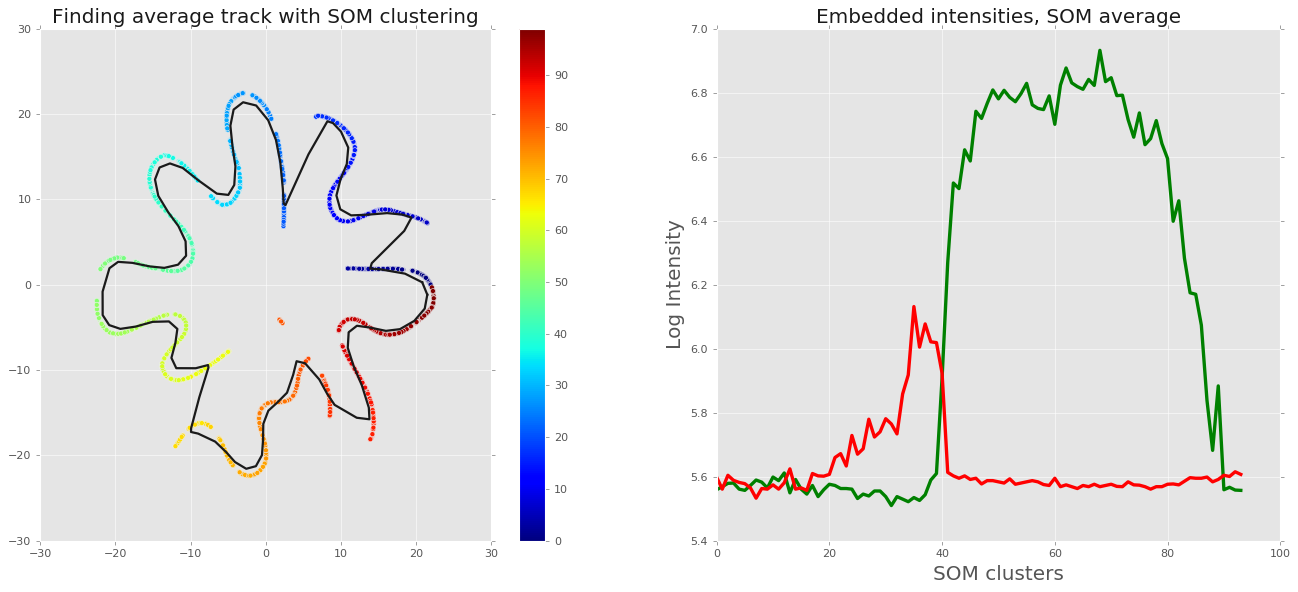

In [24]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

color = 'k'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=2, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=2, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track[:, 0], c='green', linewidth=3)
ax2.plot(som_track[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)


plt.show()

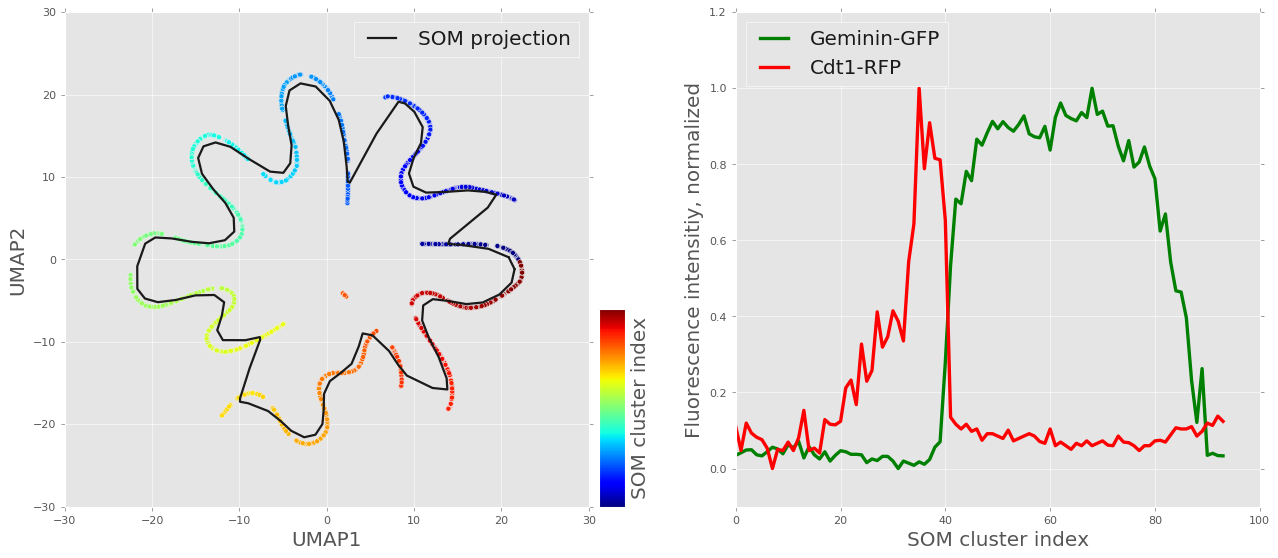

In [25]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1, 1]})

color = 'k'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=2, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=2, c=color)
ax1.set_ylabel('UMAP2', fontsize=18)
ax1.set_xlabel('UMAP1', fontsize=18)
ax1.legend(['SOM projection'], fontsize=18, loc='upper right')
axins = inset_axes(ax1,
                   width="5%",  # width = 5% of parent_bbox width
                   height="40%",  # height : 30%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
cbar = fig.colorbar(im, ax=ax1, cax=axins, ticks=[])
cbar.set_label('SOM cluster index', fontsize=18)


som_track_normalized = som_track - som_track.min(0)
som_track_normalized /= som_track_normalized.max(0)
ax2.plot(som_track_normalized[:, 0], c='green', linewidth=3)
ax2.plot(som_track_normalized[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Fluorescence intensitiy, normalized', fontsize=18)
ax2.set_xlabel('SOM cluster index', fontsize=18)
ax2.legend(['Geminin-GFP', 'Cdt1-RFP'], fontsize=18, loc='upper left')
ax2.set_ylim((-0.1, 1.2))

plt.tight_layout(pad=8)
# plt.savefig('Fig3norm.png')
plt.show()

### Project SOM averaged trajectory back onto fluo plane

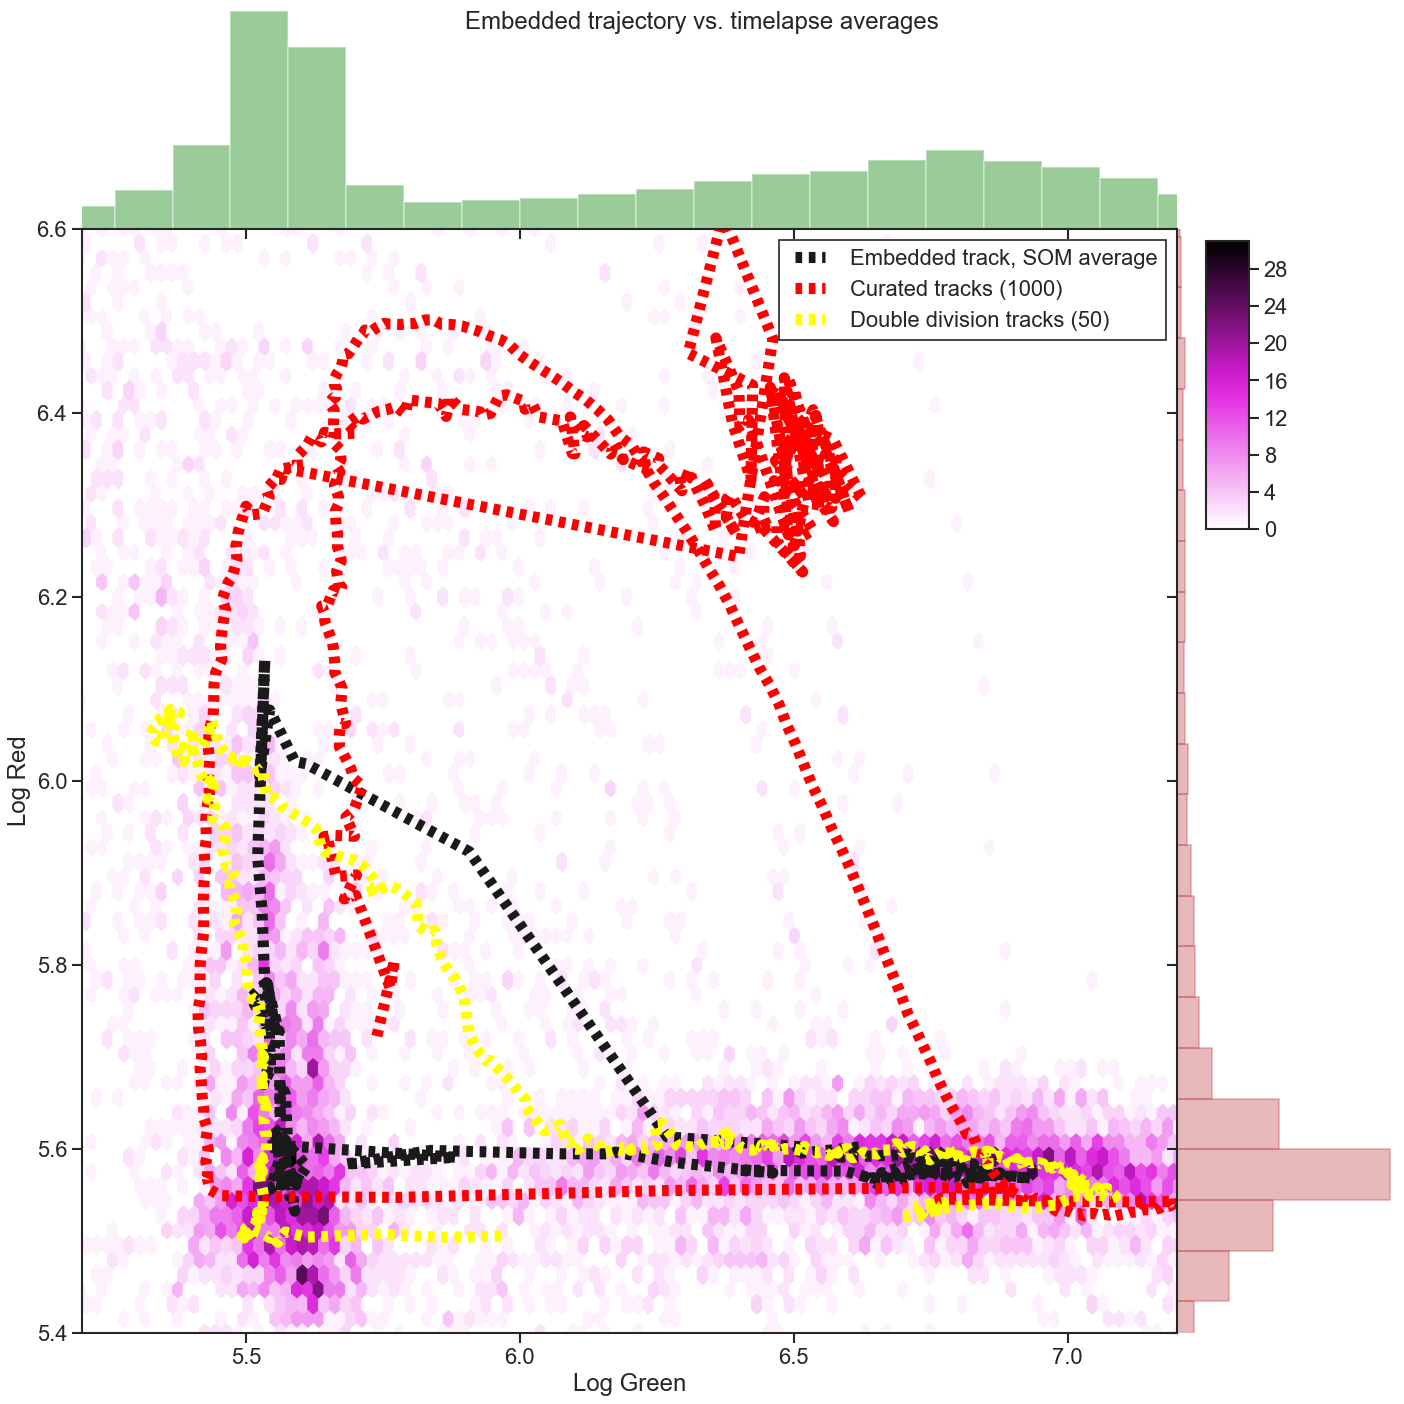

In [40]:
project_onto_fluo_plane(intensities, 
                        (som_track, 'k', 'Embedded track, SOM average'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

# Time calibration

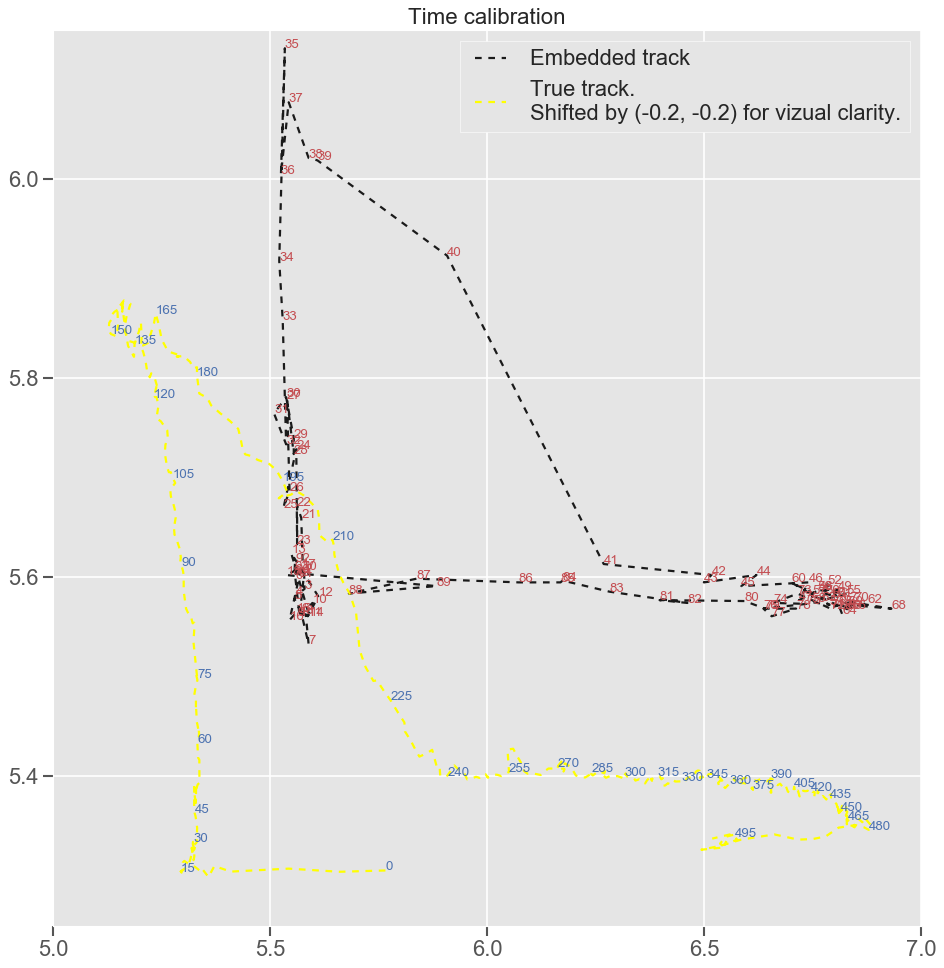

In [62]:
fontsize = 12
linewidth = 2
plt.style.use('ggplot')

plt.figure(figsize=(14, 14))
plt.plot(som_track[:, 0], som_track[:, 1], 'k', linestyle='--', linewidth=linewidth, label='Embedded track')
for i, xy in enumerate(som_track):
    plt.annotate(str(i), xy, fontsize=fontsize, color='r')


shift = (-0.2, -0.2)
true_track = np.log(average_double_division_track + log_const) + shift
plt.plot(true_track[:, 0], true_track[:, 1], 'yellow', linestyle='--', linewidth=linewidth, label=f'True track.\nShifted by ({shift[0]}, {shift[1]}) for vizual clarity.')

for i, xy in enumerate(true_track):
    if (i % 15) != 0:
        continue
    plt.annotate(str(i), xy, fontsize=fontsize, color='b')

plt.ylim((5.25, 6.15))

plt.title('Time calibration', fontsize=20)
plt.legend()
plt.show()

In [63]:
# assign corresponding waypoints
time_calibration = {
    86: 0,
    7: 15,
    30: 75,
    33: 90,
    35: 150,
    37: 165,
    39: 180,
    40: 195,
    41: 240,
    44: 330,
    50: 435,
    68: 480,
    70: 490,
    80: 495,
}

    
real_time_shift = 15
time_calibration = {k: np.mod(v - real_time_shift, len(average_double_division_track)) for k, v in time_calibration.items()}

dd_frames = np.array(list(double_division_tracks.values()))
average_track_duration = np.mean(dd_frames[:, 1] - dd_frames[:, 0]) * 10 / 60  # hours
print(f'Average track duration {average_track_duration:.2f} hours')

Average track duration 27.12 hours


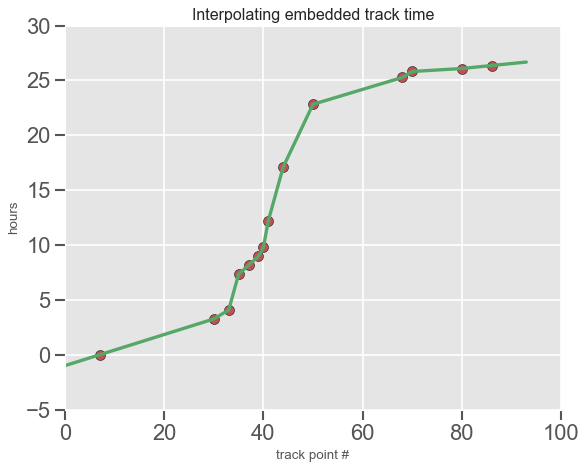

In [64]:
# find time calibration function
embd_track_time = {v: average_track_duration / len(som_track) * k for k, v in time_calibration.items()}
x = np.array(sorted(time_calibration))
y = np.array([time_calibration[i] / (len(true_track) - 1) * average_track_duration for i in x])
f = interp1d(x, y, kind='linear', fill_value='extrapolate')
xnew = np.arange(len(som_track))
ynew = f(xnew)
plt.plot(x, y, 'ro', xnew, ynew, 'g-')
plt.xlabel('track point #')
plt.ylabel('hours')
plt.title('Interpolating embedded track time')
plt.show()

### Plot in real time coordinates

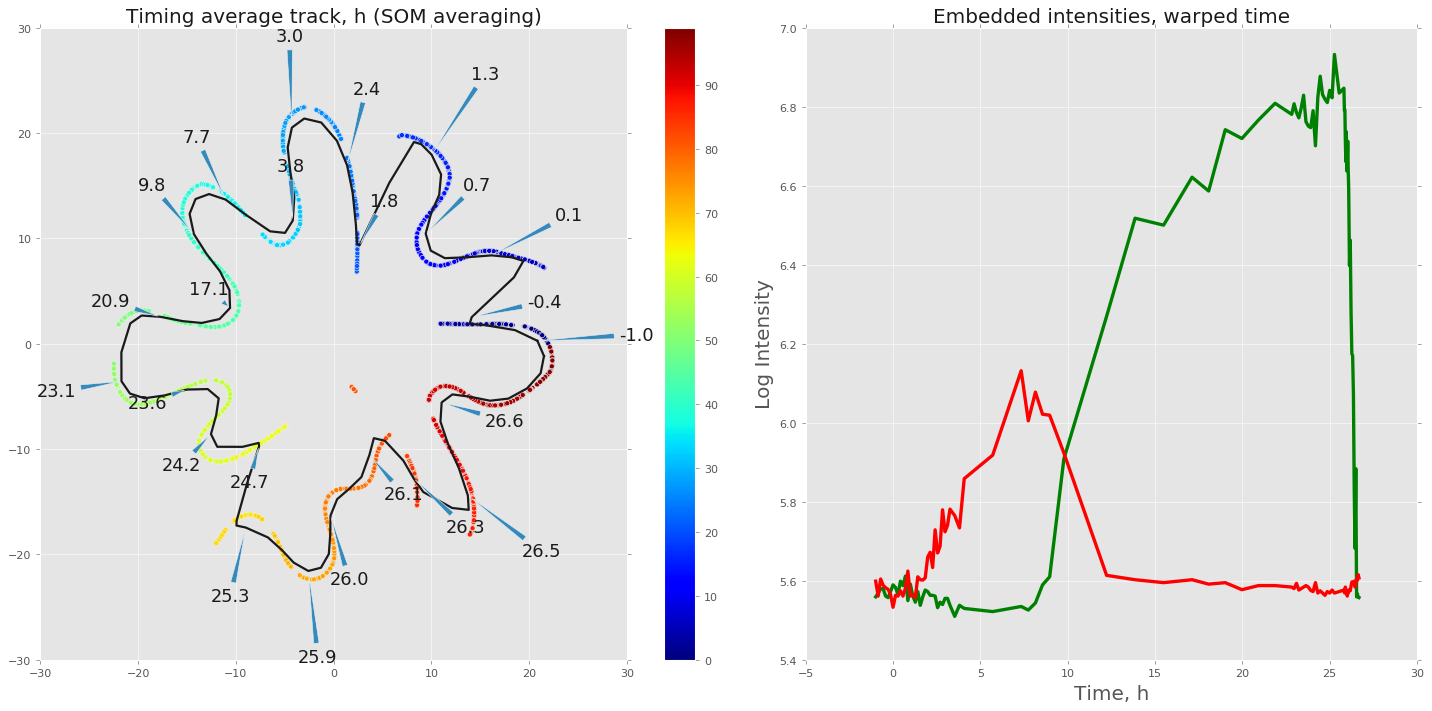

In [65]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1.2, 1]})

color = 'k'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=2, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=2, c=color)
ax1.set_title('Timing average track, h (SOM averaging)', fontsize=18)
fig.colorbar(im, ax=ax1)

for h, xy in zip(ynew[::4], som_matrix[::4]):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    ax1.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=16, color='k', arrowprops={'arrowstyle': 'wedge'})
    
ax2.plot(ynew, som_track[:, 0], c='green', linewidth=3)
ax2.plot(ynew, som_track[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('Time, h', fontsize=18)
ax2.set_title('Embedded intensities, warped time', fontsize=18)

plt.tight_layout()
plt.show()

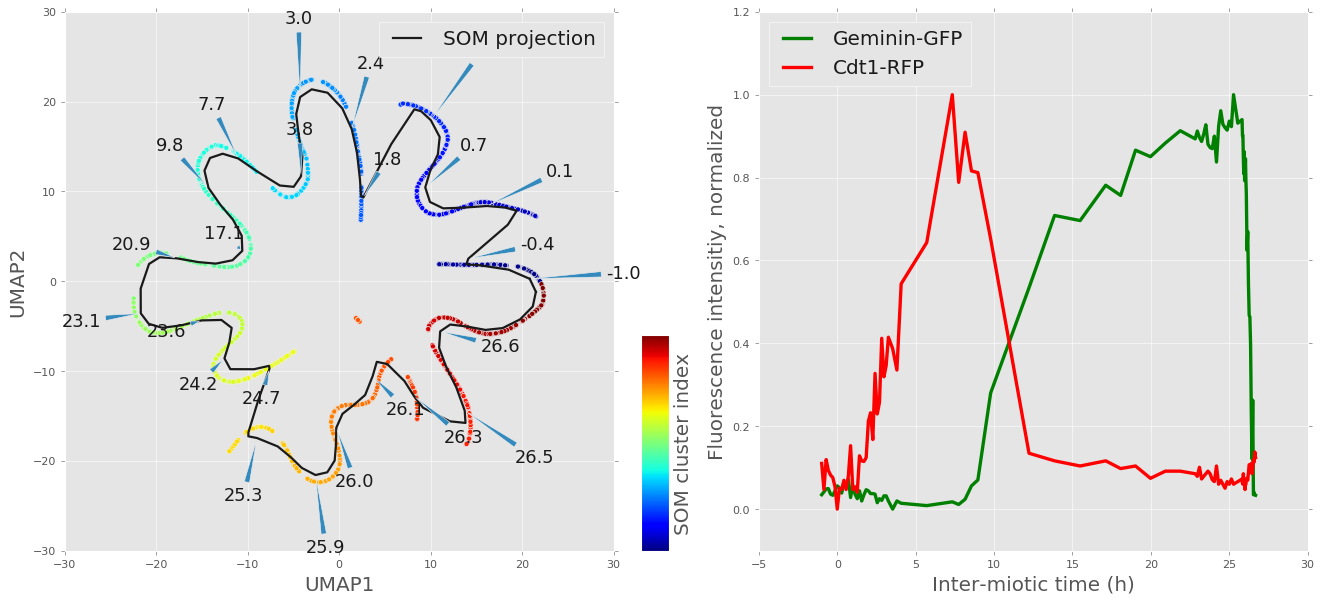

In [66]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1, 1]})

color = 'k'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=2, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=2, c=color)
ax1.set_ylabel('UMAP2', fontsize=18)
ax1.set_xlabel('UMAP1', fontsize=18)
ax1.legend(['SOM projection'], fontsize=18, loc='upper right')
axins = inset_axes(ax1,
                   width="5%",  # width = 5% of parent_bbox width
                   height="40%",  # height : 30%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
cbar = fig.colorbar(im, ax=ax1, cax=axins, ticks=[])
cbar.set_label('SOM cluster index', fontsize=18)

for h, xy in zip(ynew[::4], som_matrix[::4]):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    ax1.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=16, color='k', arrowprops={'arrowstyle': 'wedge'})

som_track_normalized = som_track - som_track.min(0)
som_track_normalized /= som_track_normalized.max(0)
ax2.plot(ynew, som_track_normalized[:, 0], c='green', linewidth=3)
ax2.plot(ynew, som_track_normalized[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Fluorescence intensitiy, normalized', fontsize=18)
ax2.set_xlabel('Inter-miotic time (h)', fontsize=18)
ax2.legend(['Geminin-GFP', 'Cdt1-RFP'], fontsize=18, loc='upper left')
ax2.set_ylim((-0.1, 1.2))

plt.tight_layout(pad=6)
# plt.savefig('Fig5norm.png')
plt.show()

In [733]:
ynew_ = f(som_translation_tbl[range(mapsize)])

origin = (0, 0) # x, y
rescale = [1, 1]
embeddings_preds_ext = embeddings_preds * rescale
som_matrix_ext = som_matrix * rescale

s_mean = som_matrix_ext - origin
phi_mean = np.arctan(s_mean[:, 1] / s_mean[:, 0])
phi_mean[s_mean[:, 0] < 0] += np.pi
phi_mean[phi_mean < 0] += 2 * np.pi
radius_mean = np.sqrt(np.square(s_mean).sum(1))

# angle in UMAP coord sysyem -> time
ft = interp1d(phi_mean, ynew_, kind='linear', bounds_error=False, fill_value=(ynew[0], ynew[-1]))

s_embeddings = embeddings_preds_ext - origin
phi_embeddings = np.arctan(s_embeddings[:, 1] / s_embeddings[:, 0])
phi_embeddings[s_embeddings[:, 0] < 0] += np.pi
phi_embeddings[phi_embeddings < 0] += 2 * np.pi
    
radius_embeddings = np.sqrt(np.square(s_embeddings).sum(1))
transformed_embeddings = ft(phi_embeddings)

transformed_mean_scaled = -ynew_ / transformed_embeddings.max() * 2 * np.pi - np.pi / 2
transformed_embeddings_scaled = -transformed_embeddings / transformed_embeddings.max() * 2 * np.pi - np.pi / 2

transformed_mean_x = np.cos(transformed_mean_scaled) * radius_mean
transformed_mean_y = np.sin(transformed_mean_scaled) * radius_mean

transformed_embeddings_x = np.cos(transformed_embeddings_scaled) * radius_embeddings
transformed_embeddings_y = np.sin(transformed_embeddings_scaled) * radius_embeddings

In [546]:
colors = ["white", "red", "yellow", "green", "white"]
nodes = [0.0, 0.05, 0.3, 0.8, 1.0]
cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))(transformed_embeddings / transformed_embeddings.max())

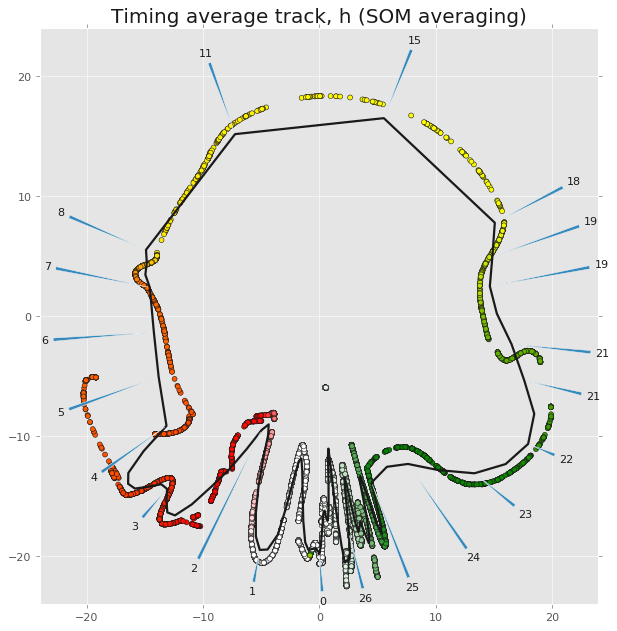

In [734]:
plt_origin = (0, 0) 
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 9))

color = 'k'
ax.scatter(transformed_embeddings_x, transformed_embeddings_y, c=cmap, edgecolors='k')
ax.plot(transformed_mean_x, transformed_mean_y, '-', linewidth=2, c=color)
ax.set_title('Timing average track, h (SOM averaging)', fontsize=18)

idx = [next(j for j, k in enumerate(ynew.astype(int)) if k == i) for i in np.unique(ynew.astype(int))] 
for h, x_, y_ in zip(ynew[idx], transformed_mean_x[idx], transformed_mean_y[idx]):
    angle = np.arctan((y_ - plt_origin[1]) / (x_ - plt_origin[0])) + ((x_ - plt_origin[0]) < 0) * np.pi
    radius = 24
    xy_ = np.array([np.cos(angle) * radius + plt_origin[0], np.sin(angle) * radius + plt_origin[1]])
    ax.annotate(f'{h:.0f}', xy=(x_, y_), xytext=xy_,  color='k', arrowprops={'arrowstyle': 'wedge'})


plt.xlim([-24, 24])
plt.ylim([-24, 24])
plt.show()

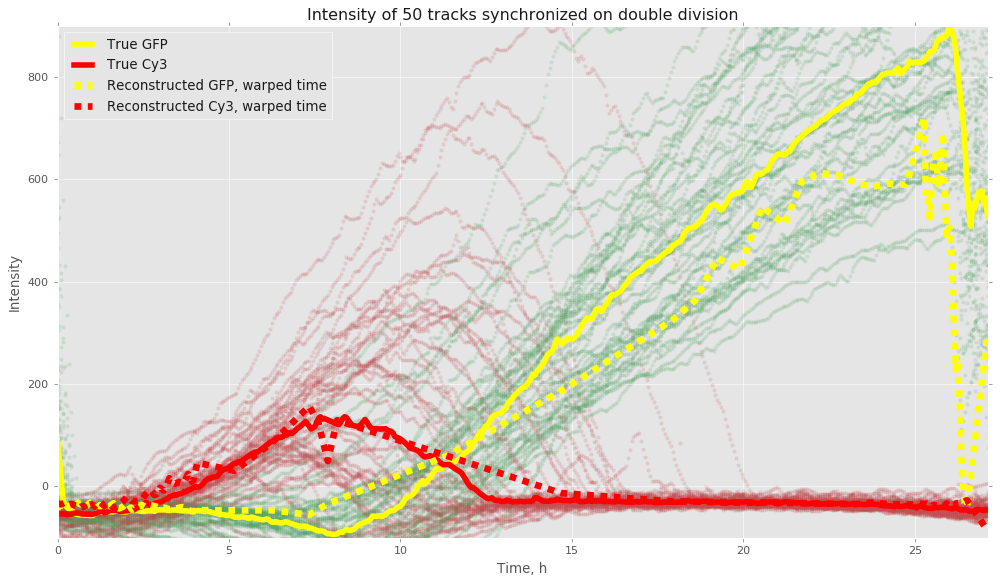

In [723]:
average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500)
x_ = ax.lines[0].get_xdata()

f_green = interp1d(ynew, np.exp(som_track[:, 0]) - log_const, kind='linear', fill_value='extrapolate')
f_red = interp1d(ynew, np.exp(som_track[:, 1]) - log_const, kind='linear', fill_value='extrapolate')
y_green = f_green(x_)
y_red = f_red(x_)

ax.plot(x_, y_green, 'yellow', x_, y_red, 'red', linestyle='--', linewidth=6)
ax.set_ylim((-100, 900))
ax.legend(ax.lines[-4:], ['True GFP', 'True Cy3', 'Reconstructed GFP, warped time', 'Reconstructed Cy3, warped time'], loc=0)
plt.show()

# Time reconstruction using unseen data

In [782]:
with open(DATA_ROOT / 'descriptors_all.cls3.r34.sz48.pkl', 'rb') as fl:
    y_all, descriptors_all, intensities_all, df_index_all = pickle.load(fl)
descriptors_all = np.log(descriptors_all + 1e-7)
intensities_all = np.log(intensities_all + log_const)
print(y_all.shape, descriptors_all.shape, intensities_all.shape)

(2684453, 3) (2684453, 3) (2684453, 2)


In [740]:
# load all dataset embeddings (obtained with all_cells_prediction.py)

embeddings_preds_all = []
for i in range(20):
    data = load(DATA_ROOT / f'cls3_embeddings_preds_all_batch{i}.npz')
    embeddings_preds_all.append(data['arr_0'])
embeddings_preds_all = np.vstack(embeddings_preds_all)

In [741]:
som_bmu_all = som_translation_tbl[som.project_data(embeddings_preds_all)]

In [753]:
fun = np.median
som_track_all = []
for cluster in np.sort(np.unique(som_bmu_all)):
    som_track_all.append(fun(intensities_all[::1][som_bmu_all == cluster], 0))
som_track_all = np.array(som_track_all)

xnew_all = np.arange(len(som_track_all))
ynew_all = f(xnew_all)

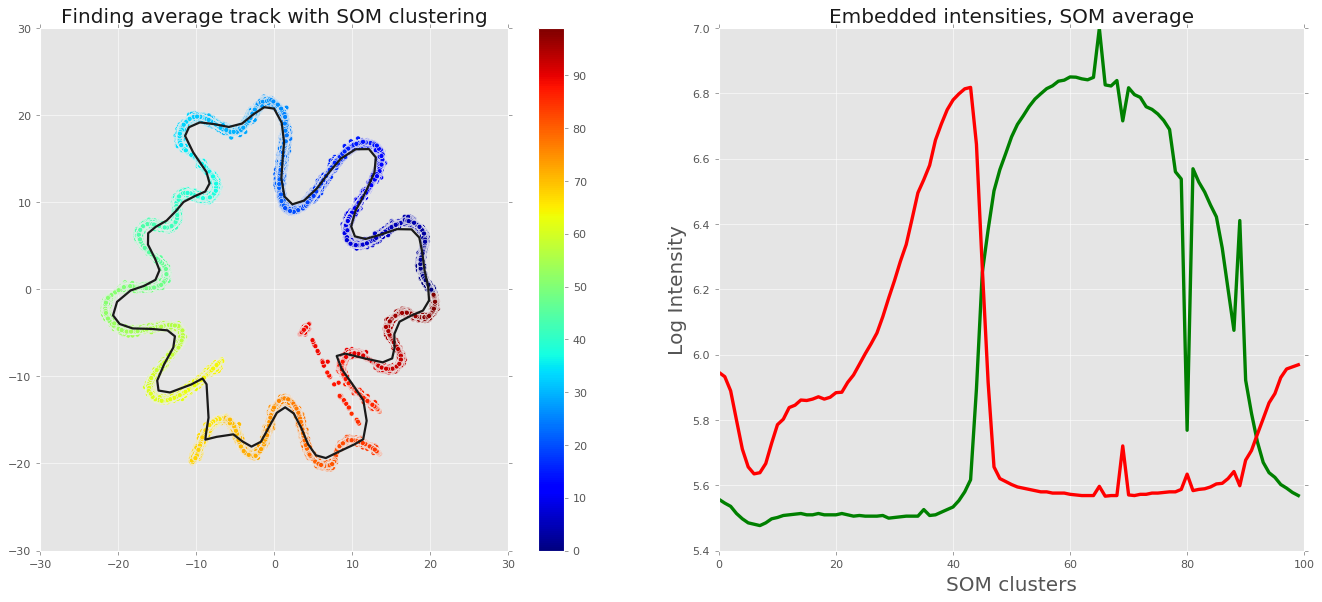

In [762]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1, 1]})

color = 'k'
im = ax1.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=som_bmu_all)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=2, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=2, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track_all[:, 0], c='green', linewidth=3)
ax2.plot(som_track_all[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)

plt.tight_layout(pad=6)
plt.show()

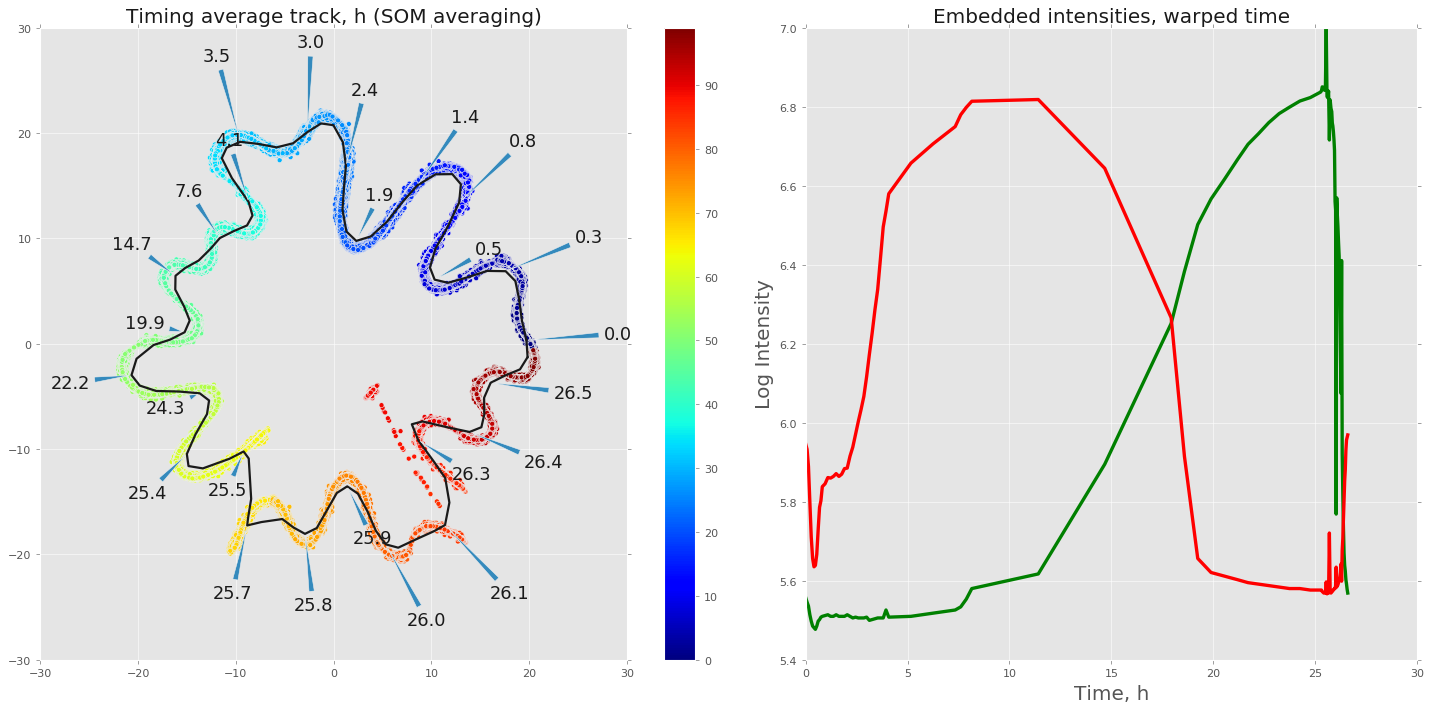

In [756]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1.2, 1]})

color = 'k'
im = ax1.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=som_bmu_all)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=2, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=2, c=color)
ax1.set_title('Timing average track, h (SOM averaging)', fontsize=18)
fig.colorbar(im, ax=ax1)

for h, xy in zip(ynew[::4], som_matrix[::4]):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    ax1.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=16, color='k', arrowprops={'arrowstyle': 'wedge'})
    
ax2.plot(ynew_all, som_track_all[:, 0], c='green', linewidth=3)
ax2.plot(ynew_all, som_track_all[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('Time, h', fontsize=18)
ax2.set_title('Embedded intensities, warped time', fontsize=18)

plt.tight_layout()
# plt.savefig('SOM.png')
plt.show()

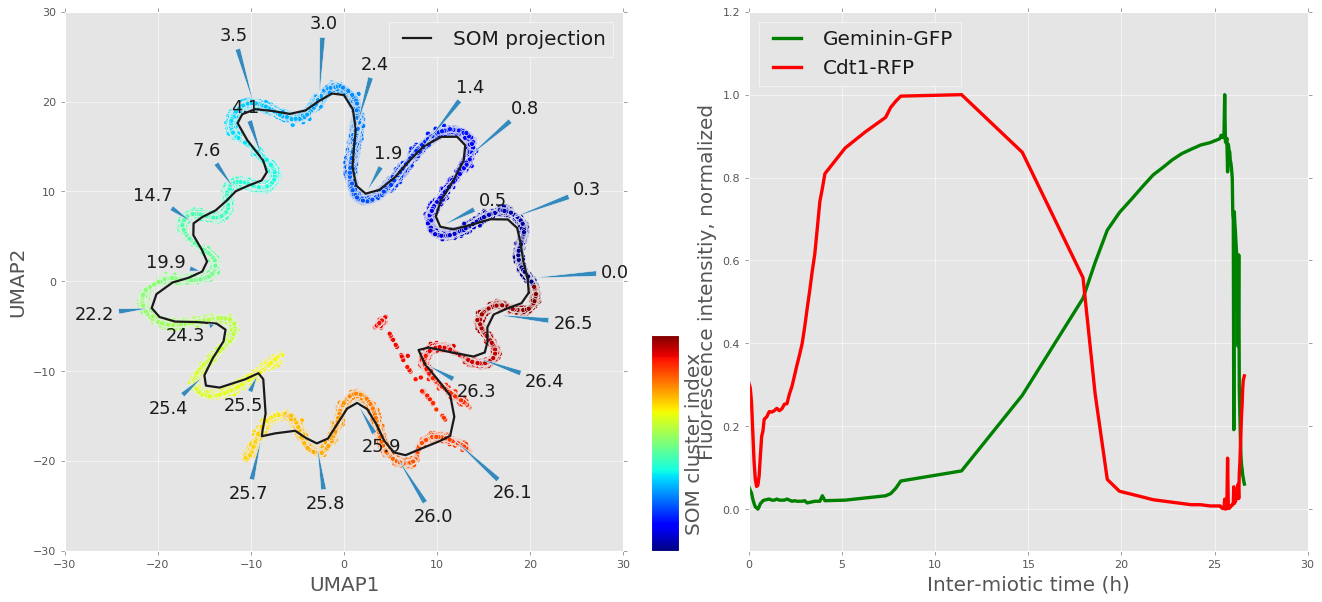

In [760]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1, 1]})

color = 'k'
im = ax1.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=som_bmu_all)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=2, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=2, c=color)
ax1.set_ylabel('UMAP2', fontsize=18)
ax1.set_xlabel('UMAP1', fontsize=18)
ax1.legend(['SOM projection'], fontsize=18, loc='upper right')
axins = inset_axes(ax1,
                   width="5%",  # width = 5% of parent_bbox width
                   height="40%",  # height : 30%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
cbar = fig.colorbar(im, ax=ax1, cax=axins, ticks=[])
cbar.set_label('SOM cluster index', fontsize=18)

for h, xy in zip(ynew[::4], som_matrix[::4]):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    ax1.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=16, color='k', arrowprops={'arrowstyle': 'wedge'})

som_track_all_normalized = som_track_all - som_track_all.min(0)
som_track_all_normalized /= som_track_all_normalized.max(0)
ax2.plot(ynew_all, som_track_all_normalized[:, 0], c='green', linewidth=3)
ax2.plot(ynew_all, som_track_all_normalized[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Fluorescence intensitiy, normalized', fontsize=18)
ax2.set_xlabel('Inter-miotic time (h)', fontsize=18)
ax2.legend(['Geminin-GFP', 'Cdt1-RFP'], fontsize=18, loc='upper left')
ax2.set_ylim((-0.1, 1.2))

plt.tight_layout(pad=6)
# plt.savefig('Fig6norm.png')
plt.show()

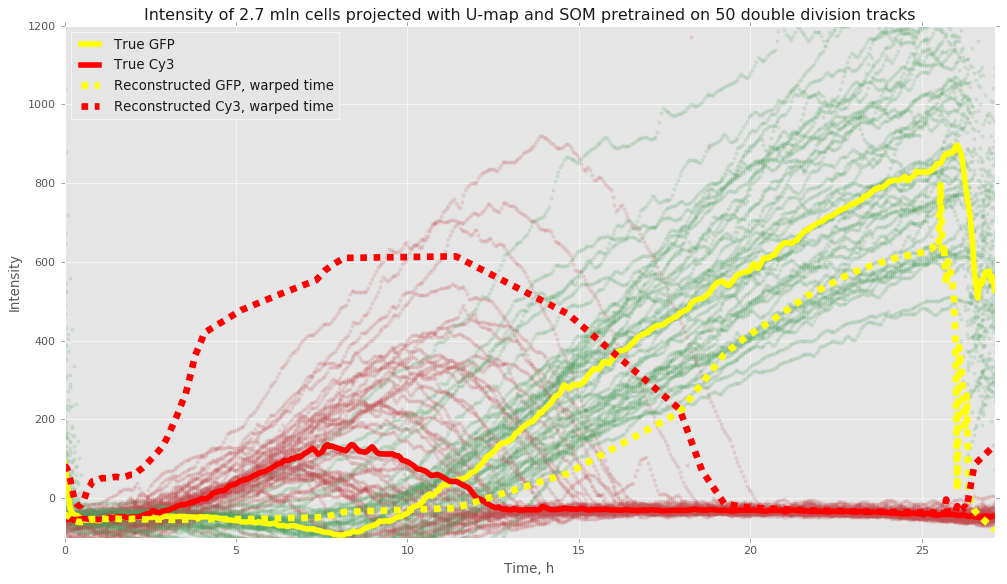

In [758]:
average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500,
                                                                  title='Intensity of 2.7 mln cells projected with U-map and SOM pretrained on 50 double division tracks')
x_ = ax.lines[0].get_xdata()

f_green = interp1d(ynew_all, np.exp(som_track_all[:, 0]) - log_const, kind='linear', fill_value='extrapolate')
f_red = interp1d(ynew_all, np.exp(som_track_all[:, 1]) - log_const, kind='linear', fill_value='extrapolate')
y_green = f_green(x_)
y_red = f_red(x_)

ax.plot(x_, y_green, 'yellow', x_, y_red, 'red', linestyle='--', linewidth=6)
ax.set_ylim((-100, 1200))
ax.legend(ax.lines[-4:], ['True GFP', 'True Cy3', 'Reconstructed GFP, warped time', 'Reconstructed Cy3, warped time'], loc=0)
plt.show()

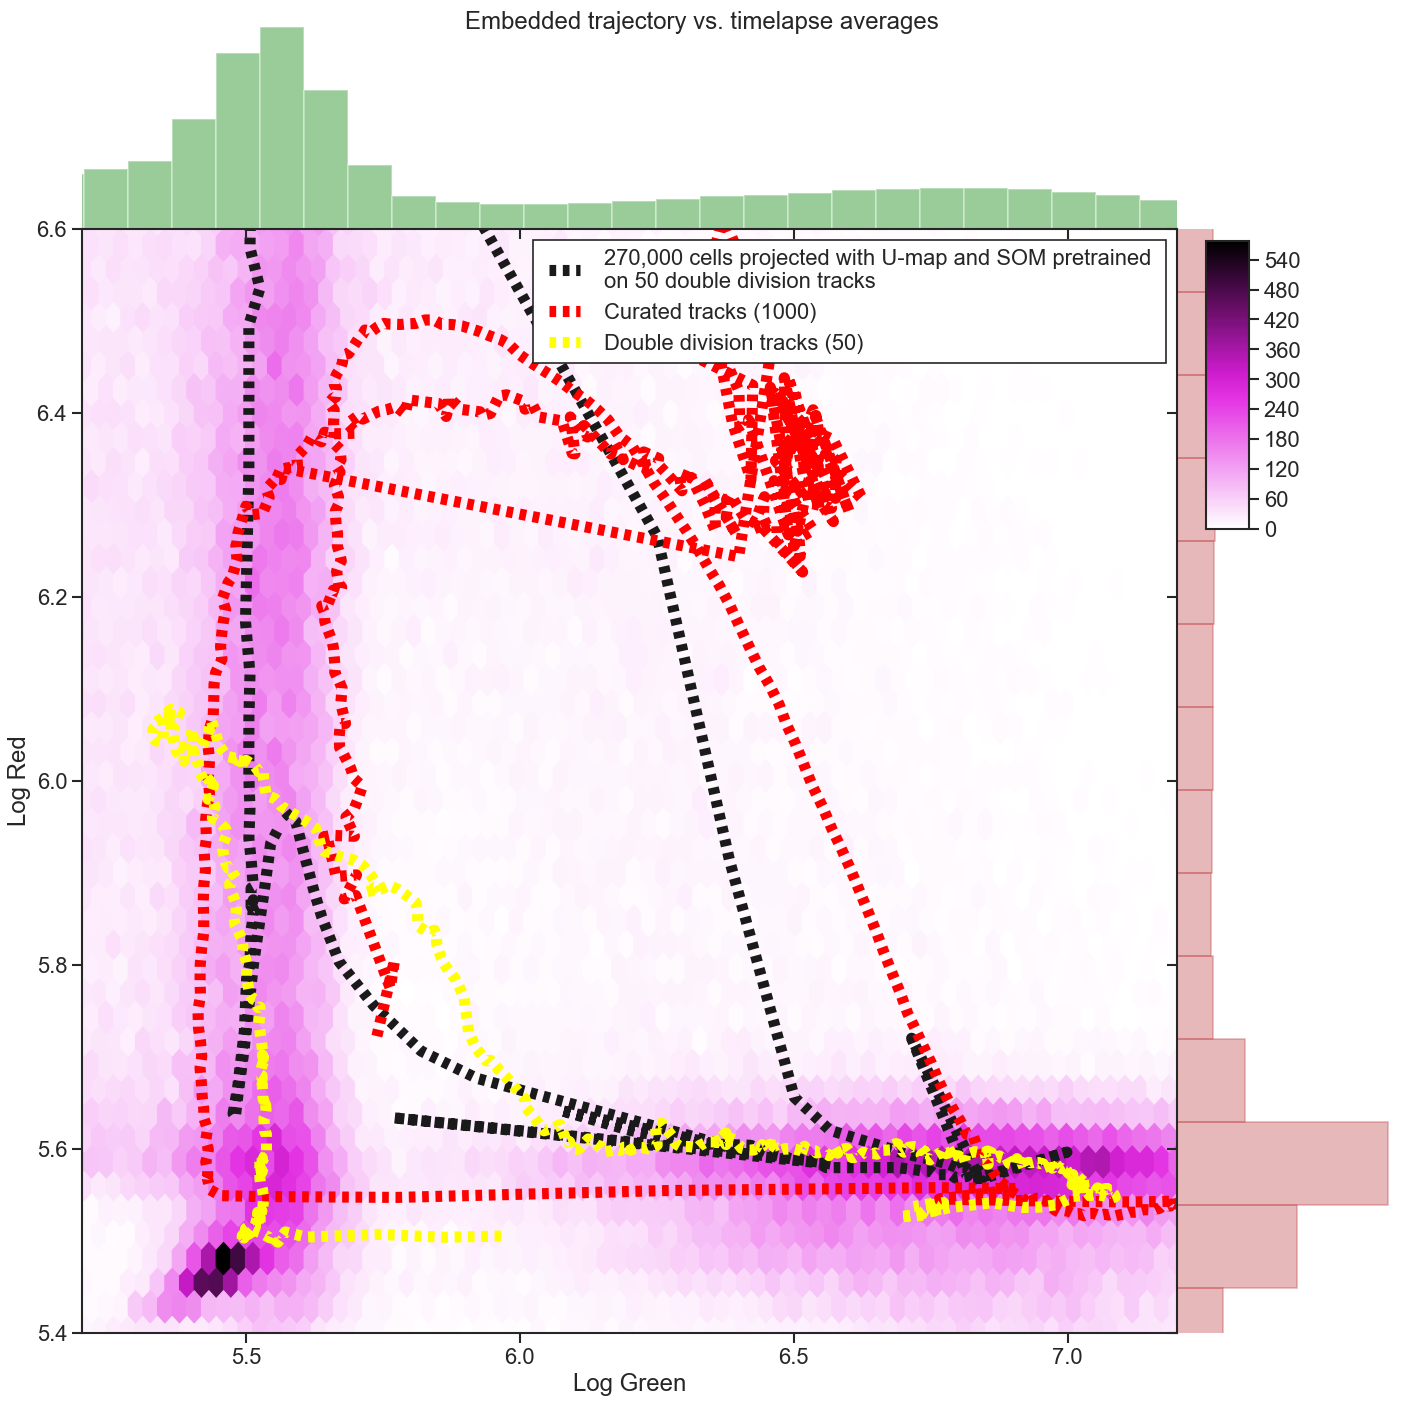

In [759]:
project_onto_fluo_plane(intensities_all[::10], 
                        (som_track_all, 'k', '270,000 cells projected with U-map and SOM pretrained \non 50 double division tracks'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

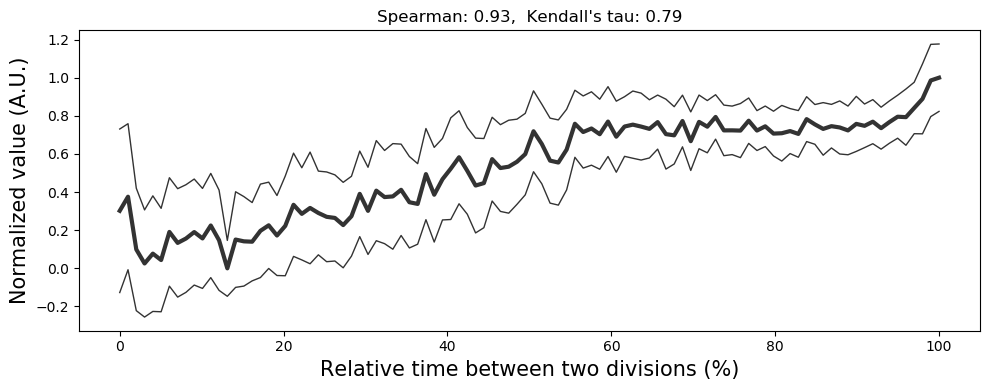

In [871]:
correlation_plot(cell_df, df_index_all, som_bmu_all, gfp_key='GFP_20', cy3_key='Cy3_20')